In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ECE_PROJECT/

Mounted at /content/drive
/content/drive/MyDrive/ECE_PROJECT


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/ECE_PROJECT


In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


# Check List


1.   Data Preparation


*   Load traing & test data, and display them with correct label ✅
*   Split training dataset with 8:2 ratio for training and validation ✅
*   Data augmentation ✅



2.   Build CNN and train


*   Create 7 layers CNN  ✅
*   Train the model with early stop  ✅

3.   Data Analysis and Improvement


*   Plot Accuracy and Loss  ✅
*   Hyperparams Tunning if necessary  ✅
*   Improve using pre-trained model  ✅

4. Model Performance on Test Data
* Accuracy check  ✅






## **Data Pre-processing**

In [6]:
import keras
print(keras.__version__)

2.15.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers.experimental.preprocessing import Rescaling, \
RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from keras.layers import Conv2D, Activation, BatchNormalization, \
MaxPooling2D, Dense, Flatten, Dropout, experimental, GlobalAveragePooling2D, \
Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical

In [20]:
base_dir = f'{HOME}/dataset/images'
SOURCE_TRAIN_DIR = f'{base_dir}/train'
SOURCE_TEST_DIR = f'{base_dir}/validation'


batch_size = 128
img_height = 48
img_width = 48

train_dataset = image_dataset_from_directory(
    SOURCE_TRAIN_DIR,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    SOURCE_TRAIN_DIR,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    SOURCE_TEST_DIR,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical',
    shuffle=False
)

Found 28821 files belonging to 7 classes.
Using 23057 files for training.
Found 28821 files belonging to 7 classes.
Using 5764 files for validation.
Found 7066 files belonging to 7 classes.


In [ ]:
def plot_imgs_with_labels(dataset, class_names):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().squeeze(), cmap='gray')
      class_index = labels[i].numpy().argmax()
      plt.title(f"{class_index} {class_names[class_index]}")
      plt.axis("off")

  plt.show()

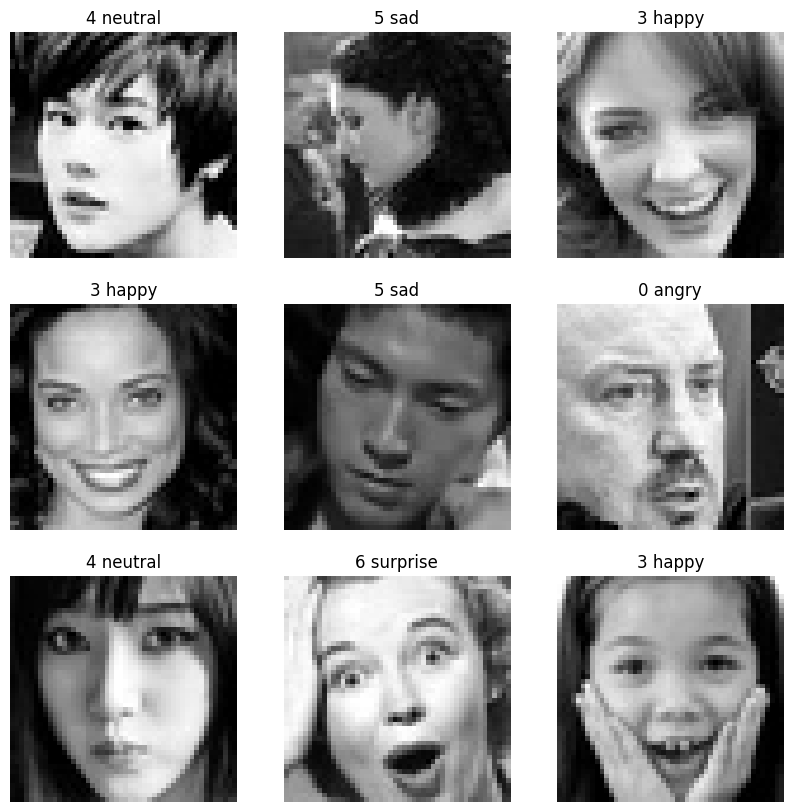

In [ ]:
plot_imgs_with_labels(train_dataset, train_dataset.class_names)

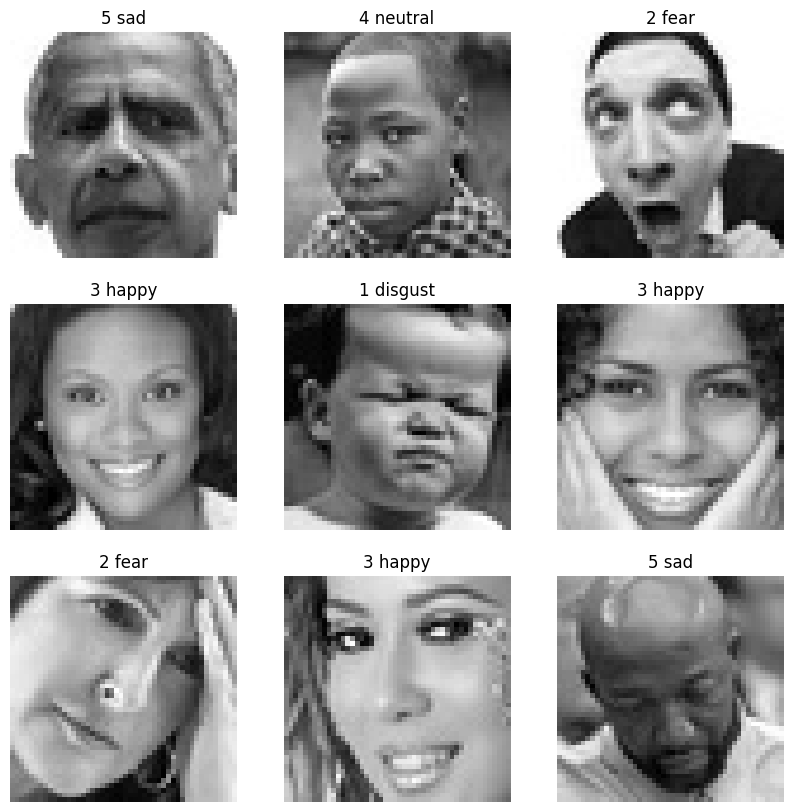

In [ ]:
plot_imgs_with_labels(test_dataset, test_dataset.class_names)

In [ ]:
class_names = train_dataset.class_names

In [ ]:
data_augmentation = Sequential([
    Rescaling(1./255),
    RandomFlip('horizontal'),
    RandomZoom(0.1),
    RandomContrast(0.2),
])

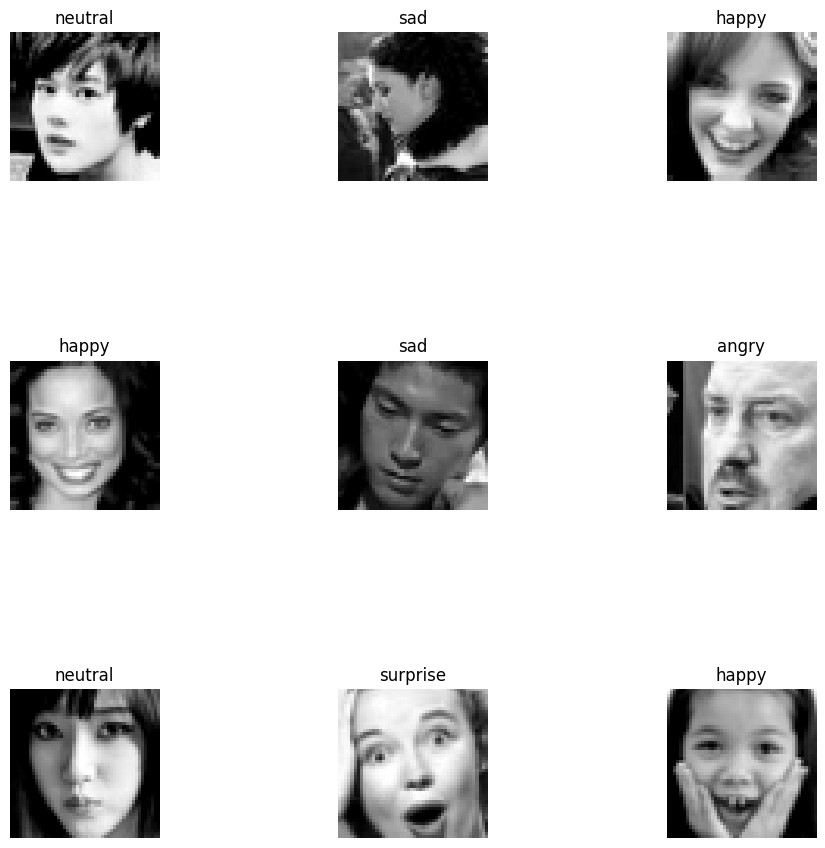

In [ ]:
for images, labels in train_dataset.take(1):
  sample_img = images[:9]
  sample_labels = labels[:9]
  augmented_images = data_augmentation(sample_img)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 6, 2*i+1)
    plt.imshow(sample_img[i].numpy().squeeze(), cmap='gray')
    plt.title(class_names[sample_labels[i].numpy().argmax()])
    plt.axis("off")

    ax = plt.subplot(3, 6, 2*i+1)
    plt.imshow(augmented_images[i].numpy().squeeze(), cmap='gray')
    plt.axis("off")

  plt.tight_layout()
  plt.show()
  break

## **Model Building**

In [ ]:
init_model = Sequential([
    Input(shape=(img_height, img_width, 1)),

    # add the augmentation layer
    data_augmentation,

    # layer 1
    Conv2D(64, (3, 3),
           padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # layer 2
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # layer 3
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # layer 4
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # flatten the output
    Flatten(),

    # fully connected layer 1
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),


    # fully connected layer 2
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # Dense(128, activation='relu'),

    # output layer
    Dense(len(class_names), activation='softmax')

])

In [ ]:
opt = Adam(learning_rate=0.001)
init_model.compile(optimizer=opt,
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
init_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 48, 48, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)       

**Training & Validation**

In [ ]:
# save the model weights that achieve the highest validation accuracy
checkpoint = ModelCheckpoint('checkpoints/best_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# stops training when a monitored metric has stopped improving:
# stops at validation loss does not improve for five consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               mode='min',
                               verbose=1,
                               patience=5,
                               restore_best_weights=True)

# reduce the lr when a metric has stopped improving
# monitor val-loss and reduce the learning rate by 0.2 after it has not
# improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=0.00001)

callbacks = [early_stopping, checkpoint, reduce_lr]

epochs = 50

In [ ]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
val_steps = tf.data.experimental.cardinality(val_dataset).numpy()

history = init_model.fit(train_dataset,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_dataset,
                         validation_steps=val_steps,
                         epochs=epochs,
                         callbacks=callbacks)

Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 1.8496 - accuracy: 0.2885
Epoch 1: val_accuracy improved from -inf to 0.17991, saving model to checkpoints/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 94s 444ms/step - loss: 1.8496 - accuracy: 0.2885 - val_loss: 1.8824 - val_accuracy: 0.1799 - lr: 0.0010
Epoch 2/50
180/181 [============================>.] - ETA: 0s - loss: 1.5500 - accuracy: 0.3998
Epoch 2: val_accuracy improved from 0.17991 to 0.32686, saving model to checkpoints/best_model.h5
181/181 [==============================] - 79s 423ms/step - loss: 1.5500 - accuracy: 0.3998 - val_loss: 1.7546 - val_accuracy: 0.3269 - lr: 0.0010
Epoch 3/50
180/181 [============================>.] - ETA: 0s - loss: 1.3864 - accuracy: 0.4664
Epoch 3: val_accuracy improved from 0.32686 to 0.38879, saving model to checkpoints/best_model.h5
181/181 [==============================] - 85s 458ms/step - loss: 1.3861 - accuracy: 0.4665 - val_loss: 1.6281 - val_accuracy: 0.3888 - lr: 0.0010
Epoch 4/50
180/181 [============================>.] - ETA: 0s - loss: 1.2990 - accuracy: 0.4988
Epoch 4: val_accuracy improved from 0.38879 to 0.49688, saving model to che

In [ ]:
import json

history_dict = {key: [float(item) for item in values]
                for key, values in history.history.items()}

json_str = json.dumps(history_dict)

with open('saved_params/history.json', 'w') as f:
    f.write(json_str)

In [ ]:
def plot_loss_and_accuracy(train_loss, val_loss,
                           train_acc, val_acc):
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(loc='lower right')

  plt.show()

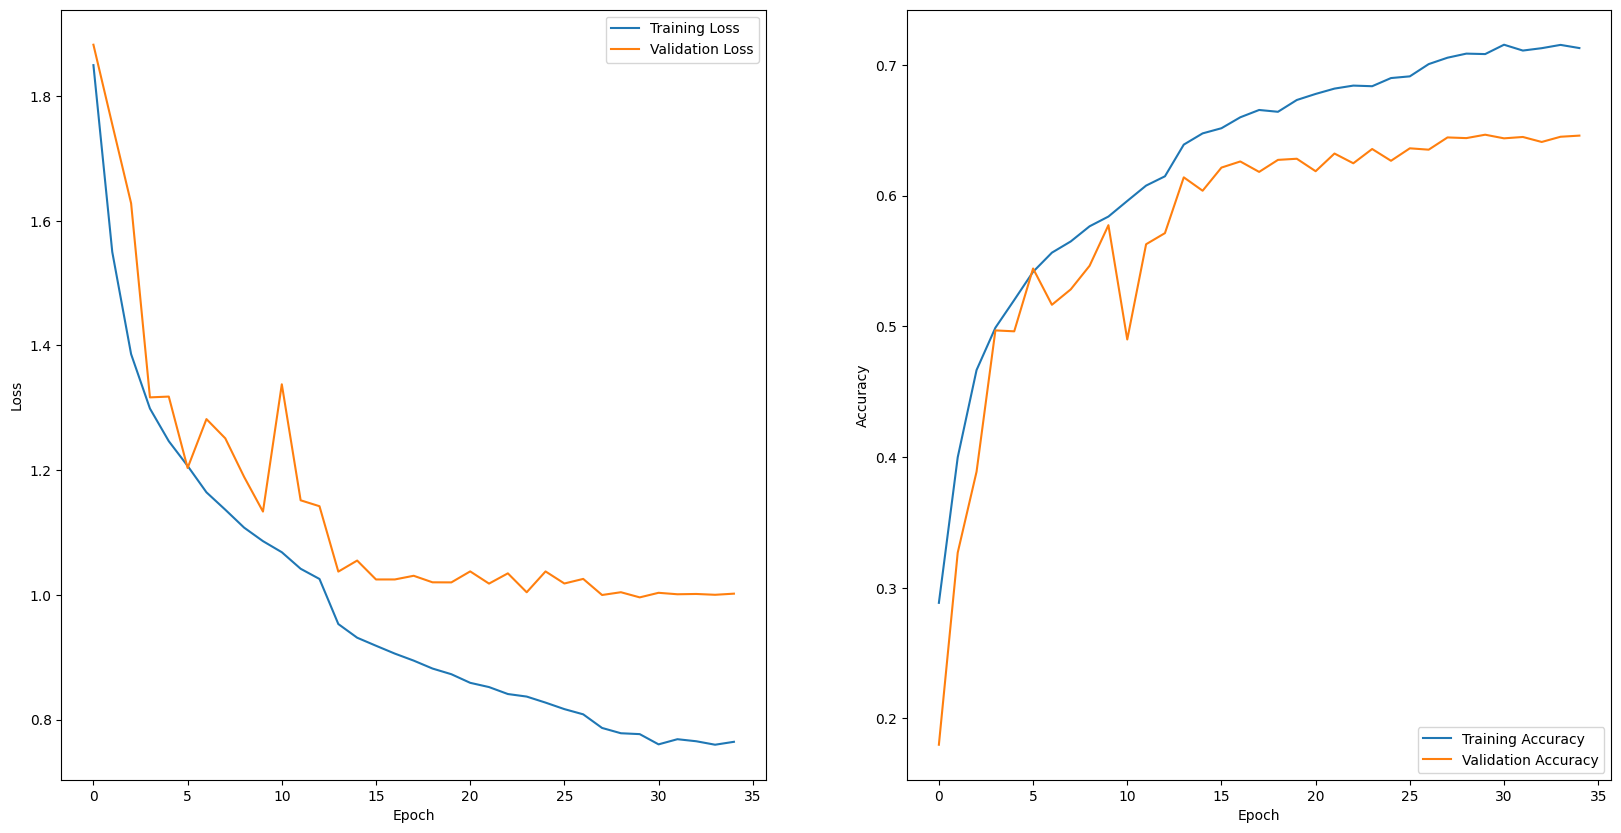

In [ ]:
history_dict = json.loads(open('saved_params/history.json').read())

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plot_loss_and_accuracy(train_loss, val_loss, train_acc, val_acc)

## **Using MobileNet**

In [ ]:
from keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(include_top=False, input_shape=(img_height,
                                                         img_width, 3))
base_model.trainable = True
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 24, 24, 32)           864       ['input_10[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 24, 24, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 24, 24, 32)           0         ['bn_Conv1[

In [ ]:
def grey_to_rgb(x):
  return tf.image.grayscale_to_rgb(x)

In [ ]:
num_classes = 7

new_model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Lambda(grey_to_rgb),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    # Dense(1024, activation='relu'),
    # Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 sequential (Sequential)     (None, 48, 48, None)      0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 512)               655872    
                                                                 
 dropout_13 (Dropout)        (None, 512)              

In [ ]:
opt = Adam(learning_rate=0.001)
new_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# save the model weights that achieve the highest validation accuracy
checkpoint = ModelCheckpoint('checkpoints/mobilenet_best_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# stops training when a monitored metric has stopped improving:
# stops at validation loss does not improve for five consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               mode='min',
                               verbose=1,
                               patience=5,
                               restore_best_weights=True)

# reduce the lr when a metric has stopped improving
# monitor val-loss and reduce the learning rate by 0.2 after it has not
# improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_lr=0.00001)

callbacks = [early_stopping, checkpoint, reduce_lr]

epochs = 50

In [ ]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
val_steps = tf.data.experimental.cardinality(val_dataset).numpy()

history = new_model.fit(train_dataset,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_dataset,
                         validation_steps=val_steps,
                         epochs=epochs,
                         callbacks=callbacks)

Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 1.6483 - accuracy: 0.3686
Epoch 1: val_accuracy improved from -inf to 0.29962, saving model to checkpoints/mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


181/181 [==============================] - 106s 428ms/step - loss: 1.6483 - accuracy: 0.3686 - val_loss: 4.0832 - val_accuracy: 0.2996 - lr: 0.0010
Epoch 2/50
180/181 [============================>.] - ETA: 0s - loss: 1.3503 - accuracy: 0.4921
Epoch 2: val_accuracy did not improve from 0.29962
181/181 [==============================] - 77s 414ms/step - loss: 1.3502 - accuracy: 0.4922 - val_loss: 2.5596 - val_accuracy: 0.2628 - lr: 0.0010
Epoch 3/50
180/181 [============================>.] - ETA: 0s - loss: 1.2448 - accuracy: 0.5292
Epoch 3: val_accuracy improved from 0.29962 to 0.42523, saving model to checkpoints/mobilenet_best_model.h5
181/181 [==============================] - 79s 424ms/step - loss: 1.2450 - accuracy: 0.5289 - val_loss: 2.7340 - val_accuracy: 0.4252 - lr: 0.0010
Epoch 4/50
180/181 [============================>.] - ETA: 0s - loss: 1.1928 - accuracy: 0.5503
Epoch 4: val_accuracy did not improve from 0.42523
181/181 [==============================] - 76s 406ms/step - 

In [ ]:
import json
history_dict = {key: [float(item) for item in values]
                for key, values in history.history.items()}

json_str = json.dumps(history_dict)

with open('saved_params/mobilenet_history.json', 'w') as f:
    f.write(json_str)

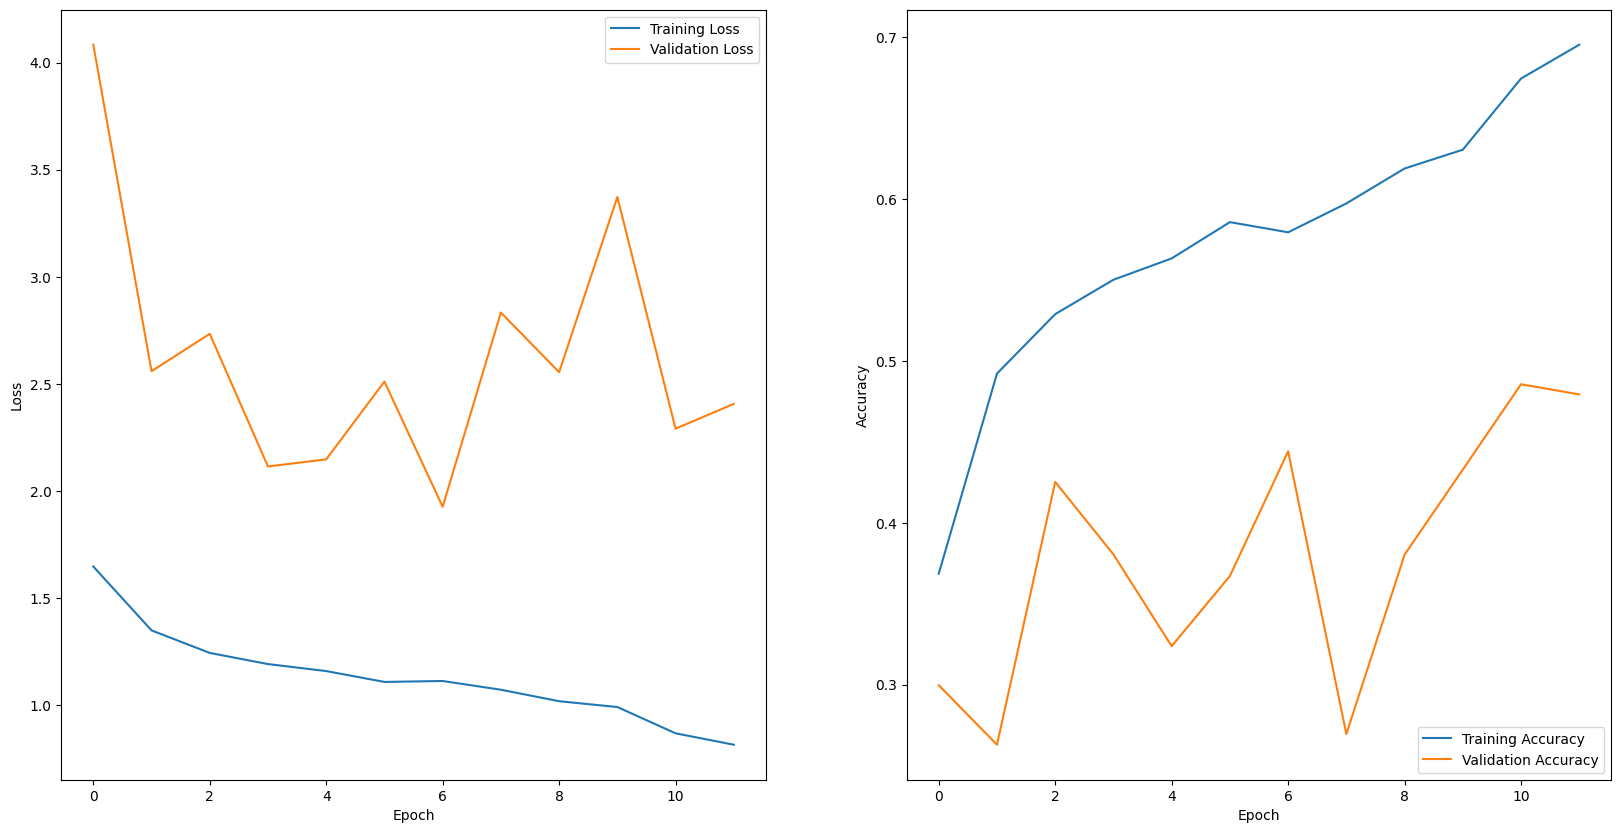

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_loss_and_accuracy(train_loss, val_loss, train_acc, val_acc)

## **ResNet**

In [ ]:
from keras.applications import ResNet101V2

In [ ]:
base_model = ResNet101V2(include_top=False,
                         input_shape=(img_height, img_width, 3))
base_model.trainable = True

img_height = 48
img_width = 48
num_classes = 7

resnet_model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    Lambda(grey_to_rgb),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    ])

resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 48, 48, 3)         0         
                                                                 
 sequential (Sequential)     (None, 48, 48, None)      0         
                                                                 
 resnet101v2 (Functional)    (None, 2, 2, 2048)        42626560  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 256)               524544    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                      

In [ ]:
opt = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# save the model weights that achieve the highest validation accuracy
checkpoint = ModelCheckpoint('checkpoints/resnet_best_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# stops training when a monitored metric has stopped improving:
# stops at validation loss does not improve for five consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               mode='min',
                               verbose=1,
                               patience=8,
                               restore_best_weights=True)

# reduce the lr when a metric has stopped improving
# monitor val-loss and reduce the learning rate by 0.2 after it has not
# improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,

                              verbose=1,
                              min_lr=0.00001)

callbacks = [early_stopping, checkpoint, reduce_lr]

epochs = 50

In [ ]:
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
val_steps = tf.data.experimental.cardinality(val_dataset).numpy()

resnet_history = resnet_model.fit(train_dataset,
                         steps_per_epoch=steps_per_epoch,
                         validation_data=val_dataset,
                         validation_steps=val_steps,
                         epochs=epochs,
                         callbacks=callbacks)

Epoch 1/50
181/181 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.5945
Epoch 1: val_accuracy improved from -inf to 0.41499, saving model to checkpoints/resnet_best_model.h5
181/181 [==============================] - 157s 579ms/step - loss: 1.0996 - accuracy: 0.5945 - val_loss: 11.3115 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 2/50
181/181 [==============================] - ETA: 0s - loss: 1.2015 - accuracy: 0.5660
Epoch 2: val_accuracy improved from 0.41499 to 0.49323, saving model to checkpoints/resnet_best_model.h5
181/181 [==============================] - 114s 614ms/step - loss: 1.2015 - accuracy: 0.5660 - val_loss: 1.3894 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 3/50
181/181 [==============================] - ETA: 0s - loss: 1.0368 - accuracy: 0.6148
Epoch 3: val_accuracy improved from 0.49323 to 0.53591, saving model to checkpoints/resnet_best_model.h5
181/181 [==============================] - 117s 633ms/step - loss: 1.0368 - accuracy: 0.6148 - val_loss

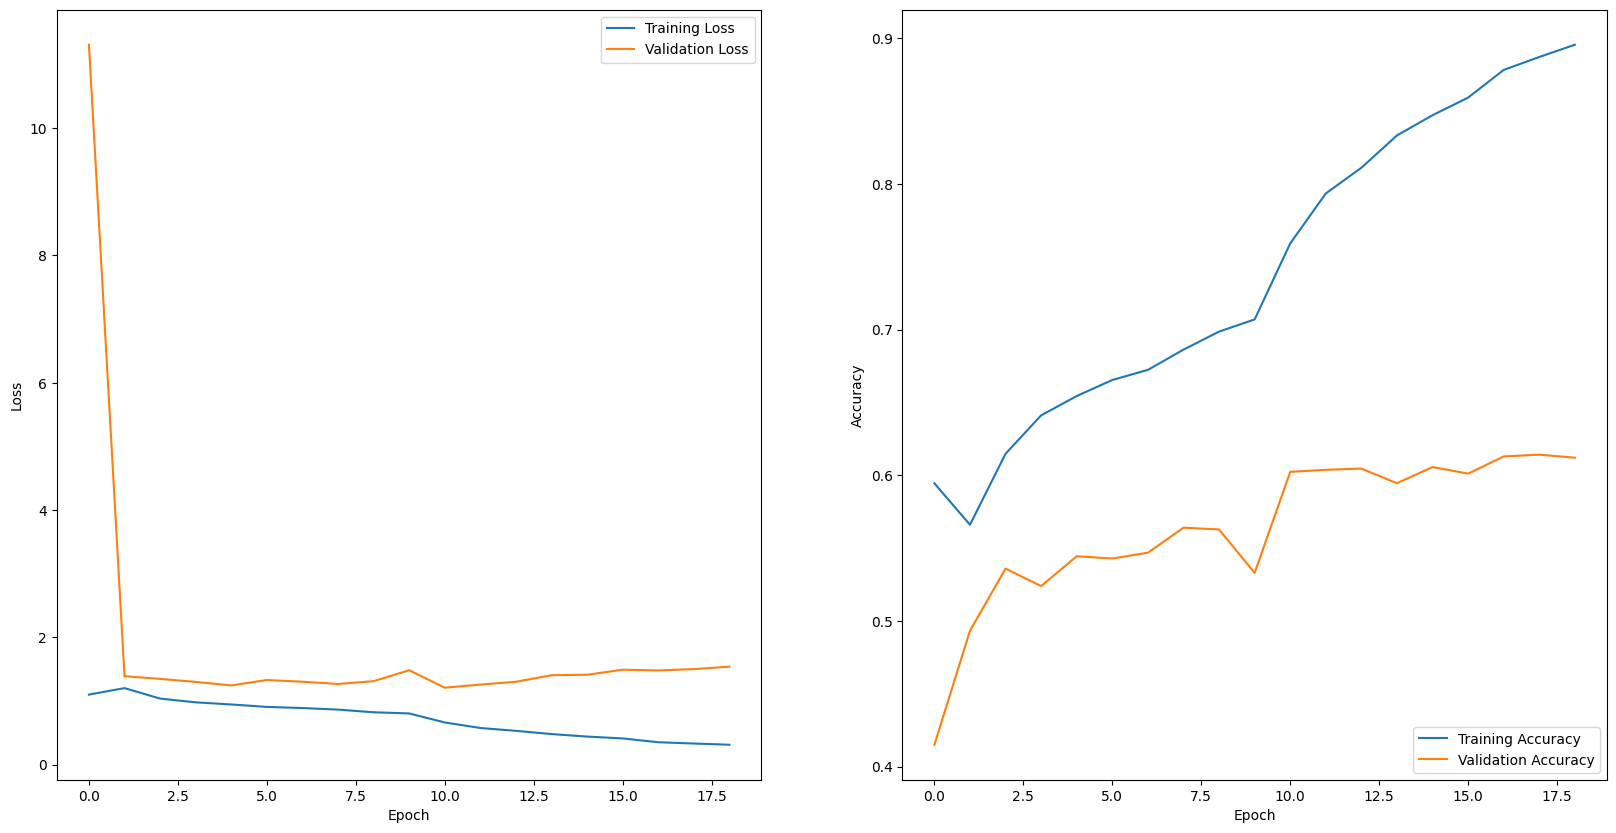

In [ ]:
import json
history_dict = {key: [float(item) for item in values]
                for key, values in resnet_history.history.items()}

json_str = json.dumps(history_dict)

with open('saved_params/resnet_history.json', 'w') as f:
    f.write(json_str)

plot_loss_and_accuracy(resnet_history.history['loss'],
                       resnet_history.history['val_loss'],
                       resnet_history.history['accuracy'],
                       resnet_history.history['val_accuracy'])

## **Evaluate the Model Performance**

### resnet model

In [26]:
from keras.models import load_model
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

new_model = load_model('checkpoints/resnet_best_model.h5')

In [27]:
loss, acc = new_model.evaluate(test_dataset)
print('Test accuracy :', acc)

56/56 [==============================] - 26s 383ms/step - loss: 1.4291 - accuracy: 0.6221
Test accuracy : 0.6221341490745544


In [29]:
y_test = []
for _, label in test_dataset:
    y_test.extend(label.numpy())

y_test = np.vstack(y_test)
y_test = np.argmax(y_test, axis=1)

y_pred = new_model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)

class_names = test_dataset.class_names

report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

56/56 [==============================] - 19s 334ms/step
              precision    recall  f1-score   support

       angry       0.53      0.50      0.52       960
     disgust       0.55      0.52      0.53       111
        fear       0.49      0.40      0.44      1018
       happy       0.81      0.85      0.83      1825
     neutral       0.52      0.64      0.58      1216
         sad       0.49      0.48      0.48      1139
    surprise       0.79      0.71      0.75       797

    accuracy                           0.62      7066
   macro avg       0.60      0.59      0.59      7066
weighted avg       0.62      0.62      0.62      7066

[[ 483   21   99   66  157  119   15]
 [  26   58   11    2    5    8    1]
 [ 130    9  411   56  144  192   76]
 [  45    1   48 1553  103   50   25]
 [  85    2   41  111  780  178   19]
 [ 113   13  145   58  255  542   13]
 [  21    2   84   63   42   16  569]]


### initial model


In [30]:
init_model = load_model('checkpoints/best_model.h5')
init_loss, init_acc = init_model.evaluate(test_dataset)
print('Test accuracy :', init_acc)

56/56 [==============================] - 31s 539ms/step - loss: 0.9544 - accuracy: 0.6633
Test accuracy : 0.6633173227310181


In [31]:
y_pred_init = init_model.predict(test_dataset)
y_pred_init = np.argmax(y_pred_init, axis=1)

report = classification_report(y_test, y_pred_init, target_names=class_names)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred_init)
print(conf_matrix)

56/56 [==============================] - 24s 427ms/step
              precision    recall  f1-score   support

       angry       0.59      0.56      0.57       960
     disgust       0.67      0.57      0.61       111
        fear       0.58      0.41      0.48      1018
       happy       0.85      0.87      0.86      1825
     neutral       0.56      0.70      0.62      1216
         sad       0.54      0.54      0.54      1139
    surprise       0.77      0.77      0.77       797

    accuracy                           0.66      7066
   macro avg       0.65      0.63      0.64      7066
weighted avg       0.66      0.66      0.66      7066

[[ 537   14   55   42  156  140   16]
 [  21   63    6    2    7    9    3]
 [ 127    4  416   46  144  180  101]
 [  36    2   27 1590   89   49   32]
 [  71    1   48   87  853  139   17]
 [ 101    8   93   52  252  618   15]
 [  17    2   67   52   32   17  610]]
